In [ ]:
%matplotlib inline 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed
from graspy.inference import LatentDistributionTest
from graspy.align import SeedlessProcrustes, SignFlips

In [ ]:
# in this example, we generate two graphs from an SBM model with 
# B = [[0.9, 0.1], [0.1, 0.9]] n=100 and p = [0.5, 0.5].
# NOTE THAT CLASS MEMEBERSHIP IS SAMPLED!
def make_graphs():
    n_1 = np.random.binomial(100, 0.5)
    ns_1 = [n_1, 100-n_1]
    n_2 = np.random.binomial(100, 0.5)
    ns_2 = [n_2, 100-n_2]
    P = [[0.9, 0.1], [0.1, 0.9]]
    A = sbm(ns_1, P)
    B = sbm(ns_2, P)
    return A, B

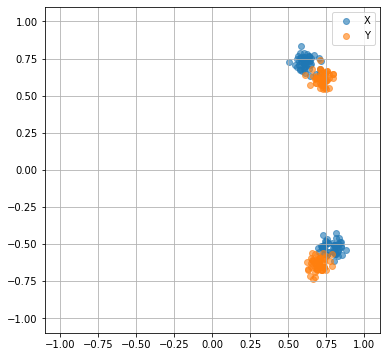

In [3]:
# In this example, the eigenvalues are close enough that the embeddings
# experiences some sort of "orthogonal offset", if one wills.
# here is a visual example of such:
np.random.seed(123)
A, B = make_graphs()
ase = AdjacencySpectralEmbed(n_components=2)
X = ase.fit_transform(A)
Y = ase.fit_transform(B)
plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(X[:,0], X[:,1], label="X", alpha=0.6)
plt.scatter(Y[:,0], Y[:,1], label="Y", alpha=0.6)
plt.xlim(-1.10, 1.10)
plt.ylim(-1.10, 1.10)
plt.legend()
plt.grid();

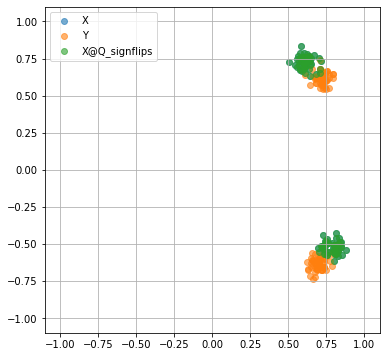

In [4]:
# note that issue cannot be overcome by simple sign flips:
# (it is exactly on top of X)
X_prime = SignFlips().fit_transform(X, Y)
plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(X[:,0], X[:,1], label="X", alpha=0.6)
plt.scatter(Y[:,0], Y[:,1], label="Y", alpha=0.6)
plt.scatter(X_prime[:,0], X_prime[:,1], label="X@Q_signflips", alpha=0.6)
plt.xlim(-1.10, 1.10)
plt.ylim(-1.10, 1.10)
plt.legend()
plt.grid();

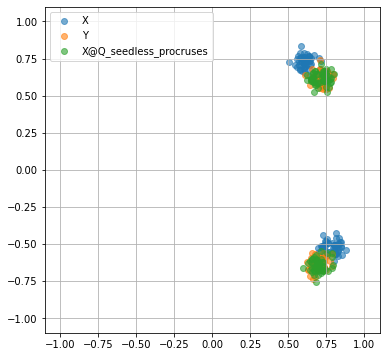

In [5]:
# but it can be overcome by seedless procrustes!
X_prime = SeedlessProcrustes().fit_transform(X, Y)
plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(X[:,0], X[:,1], label="X", alpha=0.6)
plt.scatter(Y[:,0], Y[:,1], label="Y", alpha=0.6)
plt.scatter(X_prime[:,0], X_prime[:,1], label="X@Q_seedless_procruses", alpha=0.6)
plt.xlim(-1.10, 1.10)
plt.ylim(-1.10, 1.10)
plt.legend()
plt.grid();

In [6]:
# Now, it is important to note that this has inference consequences!
# for, example, the latent distribution test for this example is not valid
# without seedless procrustes!

In [7]:
mc_iters = 1000

In [8]:
signs_p_vals = np.zeros(mc_iters)
seedless_p_vals = np.zeros(mc_iters)
for i in tqdm(range(mc_iters)):
    A, B = make_graphs()
    # run LDT with sign flips
    ldt_1 = LatentDistributionTest(test="hsic", 
                                metric="gaussian",
                                align_type="sign_flips",
                                n_components=2,
                                workers=4)
    signs_p_vals[i] = ldt_1.fit_predict(A, B)
    # run LDT with seedless
    ldt_2 = LatentDistributionTest(test="hsic", 
                                metric="gaussian",
                                align_type="seedless_procrustes",
                                n_components=2,
                                workers=4)
    seedless_p_vals[i] = ldt_2.fit_predict(A, B)

100%|██████████| 1000/1000 [20:07<00:00,  1.21s/it]


In [9]:
# not valid with only sign flips (size > 0.05), but valid with seedless (size <= 0.05)
(signs_p_vals < 0.05).mean(), (seedless_p_vals < 0.05).mean(), 

(0.422, 0.036)